In [1]:
!pip install boto3 pandas seaborn geopandas


[notice] A new release of pip available: 22.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import boto3
import pandas as pd
import pickle

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
import numpy as np
import geopandas as gpd
import itertools
import math
import predictdatascript



# Create a SageMaker client
sagemaker = boto3.client('sagemaker-runtime')

# The name of your SageMaker endpoint
endpoint_name = 'v-twac-2024'

district = "cau giay"
city = "Ha Noi"


# Handle request body
data = predictdatascript.append(district, city)
weather_forecast_df = pd.DataFrame.from_dict(data)
if len(weather_forecast_df) == 0: 
    raise Exception("Empty dataframe district")
transform_cities = weather_forecast_df.copy()

####### Feat Engineering #######
transform_cities['city'] = transform_cities['location'].apply(lambda x: city)
transform_cities['datetime'] = transform_cities['datetime']

transform_cities['is_rain'] = transform_cities.weather_description.apply(lambda x: 'rain' in x.lower())
transform_cities['is_fog'] = transform_cities.weather_description.apply(lambda x: x == 'Fog')



# Convert the DataFrame to a pickle string
payload = pickle.dumps(transform_cities)



# Send the prediction request
response = sagemaker.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType='application/python-pickle',
    Accept='application/python-pickle'
)

# Load the prediction result from the response
result = pickle.loads(response['Body'].read())



forecast_result_df_ = pd.concat([transform_cities.reset_index(drop=True), pd.DataFrame(result)], axis=1)
forecast_result_df_["timeframe"] = forecast_result_df_.datetime.apply(lambda x: x.split(":")[1])
forecast_result_df_['avg_delay'] = forecast_result_df_[[1, 2]].mean(axis=1)

forecast_result_df_
# predictdatascript.writeToCollection(forecast_result_df_)


In [11]:
def plot_result(result):
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(22, 15))
    start_hour = int(result.timeframe.reset_index(drop=True)[0])
    
    pallete_sns = ['r'] * ( 24 - start_hour)
    cycle_color = ['g', 'orange', 'r']
    for i in range(math.floor((len(result) - 24 + start_hour) / 24)):
        pallete_sns = pallete_sns + [cycle_color[i%len(cycle_color)]] * 24
         
    for k in range(3):
        sns.barplot(x = [x for x in range(start_hour, start_hour + len(result.timeframe))],
                y = result[k], ax=axes[k], palette=pallete_sns)
        
        axes[k].set_xticklabels([(x+start_hour) % 24 for x in range(len(result))])
        for j in range(len(result)):
            if (j + start_hour) % 24 == 0:
                axes[k].get_xticklabels()[j].set_fontsize(16)
                axes[k].get_xticklabels()[j].set_fontweight("bold")
        
        ax = axes[k].twinx()
        ax.grid(False)
        sns.lineplot(x = [x for x in range(len(result.timeframe))],
                y = result.precip, color='navy', marker='o', ax=ax, alpha=0.4)
        

        axes[k].set_title(f"Magnitude of delay: {k+1}")
        axes[k].set_ylim(0, result[[0 , 1, 2]].to_numpy().max())

    plt.show()

def plot_avg(result):
    fig, axes = plt.subplots(figsize=(22, 5))
    start_hour = int(result.timeframe.reset_index(drop=True)[0])

    pallete_sns = ['r'] * ( 24 - start_hour)
    cycle_color = ['g', 'orange', 'r']
    for i in range(math.floor((len(result) - 24 + start_hour) / 24)):
        pallete_sns = pallete_sns + [cycle_color[i%len(cycle_color)]] * 24


    sns.barplot(x = [x for x in range(len(result))], y = result['avg_delay'], ax=axes, palette=pallete_sns)

    ax = axes.twinx()
    ax.grid(False)
    sns.lineplot(x = [x for x in range(len(result.timeframe))],
                y = result.precip, color='navy', marker='o', ax=ax, alpha=0.4)

    ticks_label = []
    for x in range(len(result)):
        if (x + start_hour) % 24 == 0:
            temp_label = result.iloc[x].datetime.split(":")[0].split("-")[-1]
        else:
            temp_label = (x+start_hour) % 24 
        
        ticks_label.append(temp_label)
        
    axes.set_xticklabels(ticks_label)
    for j in range(len(result)):
        if (j + start_hour) % 24 == 0:
            axes.get_xticklabels()[j].set_fontsize(16)
            axes.get_xticklabels()[j].set_fontweight("bold")
    axes.set_ylim(0)
    axes.set_title(f"AVG magnitude of delay")
    plt.show()

In [12]:
forecast_result_df_[24*3: 24*8]

,app_temp,clouds,datetime,dewpt,dhi,dni,ghi,pod,pop,precip,...,weather_icon,district,city,is_rain,is_fog,0,1,2,timeframe,avg_delay
72,20.4,82,2024-01-21:04,15.4,115.54,908.93,759.35,d,0,0.0,...,c02d,cau giay,Ha Noi,False,False,0.359508,1.031265,0.731477,04,0.881371
73,20.9,77,2024-01-21:05,15.4,118.35,922.96,806.95,d,0,0.0,...,c02d,cau giay,Ha Noi,False,False,0.309066,0.912755,0.678734,05,0.795744
74,21.5,72,2024-01-21:06,15.6,116.74,914.98,779.49,d,0,0.0,...,c02d,cau giay,Ha Noi,False,False,0.395838,1.058555,1.139900,06,1.099227
75,22.0,66,2024-01-21:07,15.6,110.55,883.10,679.65,d,0,0.0,...,c02d,cau giay,Ha Noi,False,False,1.673239,2.630529,4.266811,07,3.448670
76,22.4,61,2024-01-21:08,15.5,99.00,818.48,517.52,d,0,0.0,...,c02d,cau giay,Ha Noi,False,False,1.713025,2.842361,4.279270,08,3.560815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,11.5,84,2024-01-25:23,10.9,0.00,0.00,0.00,n,0,0.0,...,c04n,cau giay,Ha Noi,False,False,0.353397,2.831130,3.388729,23,3.109929
188,11.7,87,2024-01-26:00,11.6,33.33,277.30,45.35,d,0,0.0,...,c04d,cau giay,Ha Noi,False,False,0.566089,2.862099,3.573798,00,3.217949
189,12.5,91,2024-01-26:01,11.1,73.70,649.17,257.51,d,0,0.0,...,c04d,cau giay,Ha Noi,False,False,0.364076,0.973493,1.307473,01,1.140483
190,13.5,93,2024-01-26:02,10.8,95.40,796.62,473.65,d,0,0.0,...,c04d,cau giay,Ha Noi,False,False,0.344823,0.438128,0.463392,02,0.450760


In [13]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

sns.set(style="darkgrid")

/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = [x for x in range(len(result))], y = result['avg_delay'], ax=axes, palette=pallete_sns)
/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:42: UserWarning: 
The palette list has fewer values (164) than needed (168) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = [x for x in range(len(result))], y = result['avg_delay'], ax=axes, palette=pallete_sns)
/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(ticks_label)


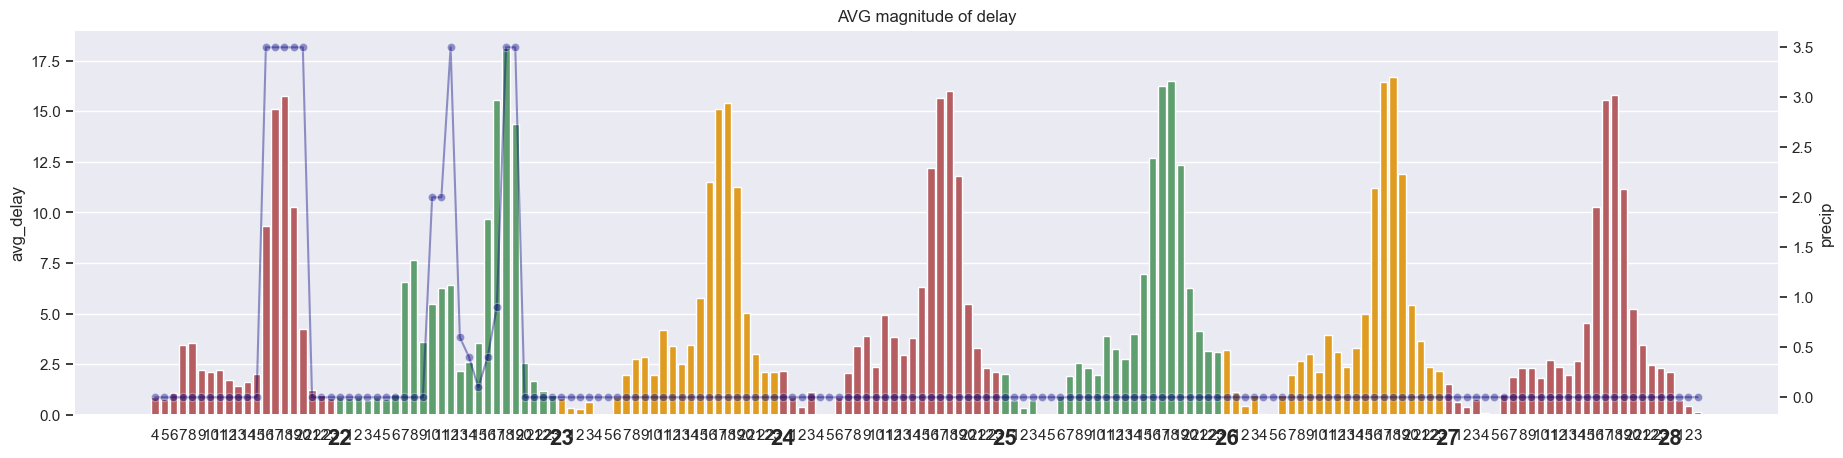

In [14]:
plot_avg(forecast_result_df_[24*3:])

In [15]:
# plot_result(forecast_result_df_[24*3:])

/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = [x for x in range(len(result))], y = result['avg_delay'], ax=axes, palette=pallete_sns)
/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:42: UserWarning: 
The palette list has fewer values (164) than needed (168) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = [x for x in range(len(result))], y = result['avg_delay'], ax=axes, palette=pallete_sns)
/var/folders/sh/qcc4f6hs6ggg504nfv9cvbv40000gn/T/ipykernel_20929/150886215.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(ticks_label)


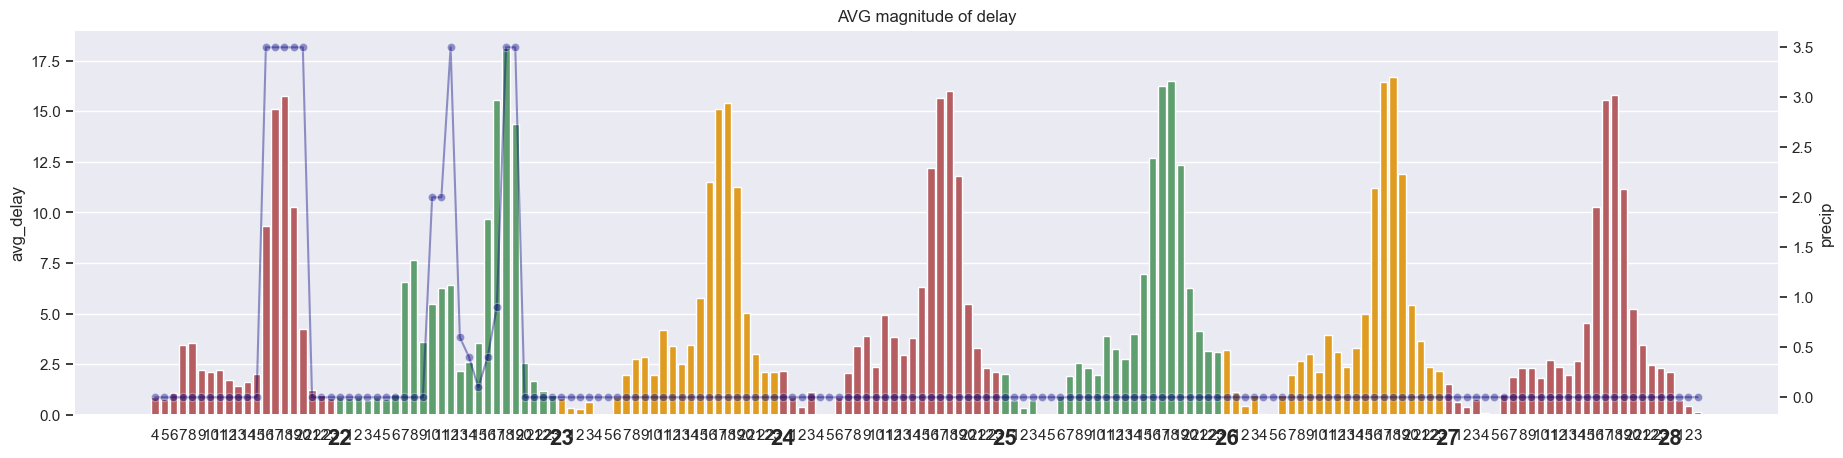

In [16]:
plot_avg(forecast_result_df_[24*3:])

In [17]:
forecast_result_df_exp = forecast_result_df_.copy()
forecast_result_df_exp['avg_delay'] = forecast_result_df_exp[[0, 1, 2]].mean(axis=1)
plot_avg(forecast_result_df_exp[24*3:])

KeyError: "None of [Int64Index([0, 1, 2], dtype='int64')] are in the [columns]"